## Подготовка

Здесь мы скачиваем и распаковываем нужные данные, устанавливаем библиотеки и так далее

In [4]:
!wget "https://www.dropbox.com/scl/fi/ahjr9509ok502d98elja6/train_dataset_vprod_train.zip?rlkey=zvu36l571mr4cau0bmafgtphe&st=bk7dhlbq&dl=0" -O train.zip

--2024-09-07 11:07:25--  https://www.dropbox.com/scl/fi/ahjr9509ok502d98elja6/train_dataset_vprod_train.zip?rlkey=zvu36l571mr4cau0bmafgtphe&st=bk7dhlbq&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3a70c0967987ec42aebf09c38.dl.dropboxusercontent.com/cd/0/inline/CaHKaReWSlEvMcQzm9lrnvAnA-SQNeWSFXPOS3dkq_3fPnPBRMtgytUGfQbTyOdcN8xo8kNk9M8Ppq21-DLvqFBya33x6iQJPrlu7Yg3WCOQNUBwS9rNijaU3mTgREkHDwxreZ2QEjfPZYFgCGGgMZ-F/file# [following]
--2024-09-07 11:07:26--  https://ucd3a70c0967987ec42aebf09c38.dl.dropboxusercontent.com/cd/0/inline/CaHKaReWSlEvMcQzm9lrnvAnA-SQNeWSFXPOS3dkq_3fPnPBRMtgytUGfQbTyOdcN8xo8kNk9M8Ppq21-DLvqFBya33x6iQJPrlu7Yg3WCOQNUBwS9rNijaU3mTgREkHDwxreZ2QEjfPZYFgCGGgMZ-F/file
Resolving ucd3a70c0967987ec42aebf09c38.dl.dropboxusercontent.com (ucd3a70c0967987ec42aebf09c38.dl.dropboxuse

In [ ]:
!unzip train.zip

In [2]:
%cd vprod_train

[Errno 2] No such file or directory: 'vprod_train'
/home/jupyter/work/resources/vprod_train


In [4]:
%pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Импортирование библиотек

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymorphy2
import pymystem3
import re
import pickle
import sentence_transformers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

import torch
from torch import nn


SEED = 8642
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Чтение данных

Колонку `achievements_modified` решили выбросить, так как там отличия от `achievements` в очень малом количестве случаев

In [4]:
df_res1 = pd.read_csv('TRAIN_RES_1.csv').drop(columns=['achievements_modified', 'id_cv'])
df_res1

,achievements,company_name,demands,job_title
0,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",инспектор
1,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,инспектор
2,"Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,геолог
3,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,геолог
4,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,геолог
...,...,...,...,...
1999995,Мое резюме на hh.ru:https://hh.ru/resume/134eb...,Текта Групп,Мое резюме на hh.ru:https://hh.ru/resume/134eb...,менеджер
1999996,NaN,"ООО""Роста""",Сортировка заказов,сортировщик
1999997,NaN,ООО ВансладРитейл,Планировать и контролировать выполнение заказо...,диспетчер
1999998,NaN,"ООО ""Агроторг""",Продажи алкогольной продукции. Контроль дебито...,представитель


In [5]:
df_res2 = pd.read_csv('TRAIN_RES_2.csv').drop(columns=['achievements_modified', 'id_cv'])
df_res2

,achievements,company_name,demands,job_title
0,В процессе всего периода 100% работа всех ввер...,"ООО ""Компания Диэлектрик""",прием и обработка заказов клиентов| ведение и ...,менеджер
1,В процессе всего периода 100% работа всех ввер...,"ООО ""ПКФ Диэлектрик""",прием и обработка заказов клиентов| ведение и ...,менеджер
2,В процессе всего периода 100% работа всех ввер...,"ООО ""Компания Диэлектрик""",прием и обработка заказов клиентов| ведение и ...,менеджер
3,В процессе всего периода 100% работа всех ввер...,"ООО ""ТД ""Диэлектрик""",прием и обработка заказов клиентов| ведение и ...,менеджер
4,NaN,"ООО ПКФ ""Вавилон""",Продажи алкогольной продукции. Контроль дебито...,представитель
...,...,...,...,...
1999995,NaN,"ООО ""УРАЛКАМ""",Привлечение новых клиентов и работа с уже имею...,менеджер
1999996,NaN,"ООО ""ЧЕЛЯБИНСК ВОСТОК СЕРВИС""","Мониторинг ЭП, подготовка и участие в торгах, ...",специалист
1999997,NaN,Находка,"Консультирование, работа на кассе, работа в 1С...",продавец
1999998,NaN,Парамода,консультирование и работа на кассе,продавец


In [6]:
df_res3 = pd.read_csv('TRAIN_RES_3.csv').drop(columns=['achievements_modified', 'id_cv'])
df_res3

,achievements,company_name,demands,job_title
0,NaN,"ООО ""Левита"" (отель Дерябинъ)",Встреча гостей. Оформление прибывших гостей в ...,администратор
1,NaN,"ООО УК ""Парус""",Консультирование жильцов МКД по общим вопросам...,администратор
2,NaN,"ООО ""ДЕЙВОН Спринг энд Сит""",- Контроль импортных закупок - Работа с докуме...,специалист
3,NaN,ООО Трия,"Консультация по ассортименту мебели, составлен...",менеджер
4,NaN,АО ОТП банк,Консультирование | Оформление | Отчётность|,эксперт
...,...,...,...,...
1999995,NaN,ООО Огольцова,"Выкладка товара, соблюдение порядка",продавец
1999996,NaN,Газпромтранс,Техническое обслуживание и ремонт автомбилей,автослесарь
1999997,NaN,Красноармейское автотранспортное предприятие,Техническое обслуживание и ремонт автомобилей,слесарь
1999998,NaN,Аксель-Моторс,Техническое обслуживание и ремонт автомобилей,автослесарь


### Проверяем на наличие пропущенных значений

In [7]:
df_res1.isna().sum()

achievements    1682725
company_name       1577
demands           15806
job_title             0
dtype: int64

In [14]:
df_res2.isna().sum()

achievements    1701059
company_name        761
demands           16468
job_title             0
dtype: int64

In [15]:
df_res3.isna().sum()

achievements    1713982
company_name        539
demands           26046
job_title             0
dtype: int64

### Соединяем и получаем большой датафрейм, чтобы удобнее работать с данными

In [8]:
df_big = pd.concat([df_res1, df_res2, df_res3], axis=0)
df_big = df_big.reset_index(drop=True)
df_big

,achievements,company_name,demands,job_title
0,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",инспектор
1,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,инспектор
2,"Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,геолог
3,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,геолог
4,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,геолог
...,...,...,...,...
5999995,NaN,ООО Огольцова,"Выкладка товара, соблюдение порядка",продавец
5999996,NaN,Газпромтранс,Техническое обслуживание и ремонт автомбилей,автослесарь
5999997,NaN,Красноармейское автотранспортное предприятие,Техническое обслуживание и ремонт автомобилей,слесарь
5999998,NaN,Аксель-Моторс,Техническое обслуживание и ремонт автомобилей,автослесарь


## Очистка данных

### Регулярное выражение для выделения чистого текста 

In [9]:
def clean_text(text: str):
    return re.sub(r'[^A-Za-z0-9А-Яа-яЁё]+', ' ', text)

In [10]:
df_big = df_big[~(df_big['achievements'].isna() & df_big['company_name'].isna() & df_big['demands'].isna())]
df_big

,achievements,company_name,demands,job_title
0,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",инспектор
1,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,инспектор
2,"Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,геолог
3,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,геолог
4,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,геолог
...,...,...,...,...
5999995,NaN,ООО Огольцова,"Выкладка товара, соблюдение порядка",продавец
5999996,NaN,Газпромтранс,Техническое обслуживание и ремонт автомбилей,автослесарь
5999997,NaN,Красноармейское автотранспортное предприятие,Техническое обслуживание и ремонт автомобилей,слесарь
5999998,NaN,Аксель-Моторс,Техническое обслуживание и ремонт автомобилей,автослесарь


### Анализ количества профессий

In [19]:
df_big['job_title'].nunique()  # количество уникальных профессий

1832

In [20]:
# z-score для каждой профессии по ее частоте в датасетах, выводим топ-120 значений
((df_big['job_title'].value_counts() - df_big['job_title'].value_counts().mean()) / df_big['job_title'].value_counts().std())[:120]

специалист                 21.930902
менеджер                   21.252891
бухгалтер                  13.054824
инженер                    10.379067
продавец                    9.841400
                             ...    
архитектор                  0.116600
оперуполномоченный          0.112586
переводчик                  0.112173
матрос                      0.105594
начальник отдела кадров     0.102863
Name: job_title, Length: 120, dtype: float64

### Выделяем топ-n профессий

In [11]:
n_job_titles = 120
top_jobs = df_big['job_title'].value_counts().index.tolist()[:n_job_titles]
top_jobs[:10]

['специалист',
 'менеджер',
 'бухгалтер',
 'инженер',
 'продавец',
 'оператор',
 'водитель',
 'директор',
 'администратор',
 'заместитель']

In [12]:
df_trim = df_big[df_big['job_title'].isin(top_jobs)].reset_index(drop=True)
df_trim

,achievements,company_name,demands,job_title
0,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",инспектор
1,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,инспектор
2,NaN,Администрация Северо-Байкальского района п.Ниж...,"Разработка программ развития района, статистич...",заместитель
3,"Удалось нормализовать работу ЗАО ""Тоннель""",ОАО «Бамтоннельстрой» (дочернии предприятия ЗА...,Финансово-экономический контроль за работой до...,заместитель
4,NaN,"ОАО «БАЙКАЛГЕО» п. Нижнеангарск, Бурятия",Проведение геологоразведочных работ на россыпн...,заместитель
...,...,...,...,...
5483250,NaN,ООО Огольцова,"Выкладка товара, соблюдение порядка",продавец
5483251,NaN,Газпромтранс,Техническое обслуживание и ремонт автомбилей,автослесарь
5483252,NaN,Красноармейское автотранспортное предприятие,Техническое обслуживание и ремонт автомобилей,слесарь
5483253,NaN,Аксель-Моторс,Техническое обслуживание и ремонт автомобилей,автослесарь


### Очистим дубликаты и заменим пропуски в данных на пустые строки

In [13]:
df_trim = df_trim.fillna('')
df_trim = df_trim.drop_duplicates().reset_index(drop=True)
df_trim

,achievements,company_name,demands,job_title
0,,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",инспектор
1,,Администрация города Сердобска,Работа с реестром муниципальной собственности,инспектор
2,,Администрация Северо-Байкальского района п.Ниж...,"Разработка программ развития района, статистич...",заместитель
3,"Удалось нормализовать работу ЗАО ""Тоннель""",ОАО «Бамтоннельстрой» (дочернии предприятия ЗА...,Финансово-экономический контроль за работой до...,заместитель
4,,"ОАО «БАЙКАЛГЕО» п. Нижнеангарск, Бурятия",Проведение геологоразведочных работ на россыпн...,заместитель
...,...,...,...,...
3567104,,ООО Огольцова,"Выкладка товара, соблюдение порядка",продавец
3567105,,Газпромтранс,Техническое обслуживание и ремонт автомбилей,автослесарь
3567106,,Красноармейское автотранспортное предприятие,Техническое обслуживание и ремонт автомобилей,слесарь
3567107,,Аксель-Моторс,Техническое обслуживание и ремонт автомобилей,автослесарь


In [34]:
df_trim['job_title'].value_counts()

специалист            355262
менеджер              353556
бухгалтер             217040
инженер               166580
продавец              153464
                       ...  
каменщик                4025
столяр                  3861
кухонный рабочий        3774
матрос                  3663
оперуполномоченный      3563
Name: job_title, Length: 120, dtype: int64

### Наконец, выберем случайное подмножество датасета

Это можно сделать, так как датасет огромный, а при случайной выборке должно совпасть распределение меток объектов

In [20]:
df_small = df_trim.sample(n=df_trim.shape[0]//5).reset_index(drop=True)
df_small

,achievements,company_name,demands,job_title
0,,"ооо"" Технофактор""","Реализация инструмента,сварочного оборудования...",менеджер
1,,"БУЗ Орловской области ""Родильный дом""",Санитарная уборка и поддержание чистоты в поме...,уборщица
2,,МКДОУ Д\С №41,планирование и осуществление воспитательно-обр...,воспитатель
3,,"ООО ""ТД Интерторг""",Общее руководство тремя службами: служба проек...,директор
4,"В ООО УК ""Изумрудный город"" работал в качестве...","ООО""Управляющая Компания ""Изумрудный город"" г....","Во время работы в ООО УК ""Изумрудный город"" ра...",инженер
...,...,...,...,...
713416,,"МЦ ""Паритет""","Организаторская деятельность на предприятии,от...",администратор
713417,"За два года, что руководила организацией, доби...","ООО ""Абсолютные Измерения""",Выполняемые обязанности: выполнение функции ис...,директор
713418,,ОАО « КБ «КЕДР» г. Красноярск,Работа с агентствами недвижимости и автосалона...,специалист
713419,,"ООО ""Галактика""",Обеспечение рекламной деятельности сети фитнес...,менеджер


In [21]:
df_small['job_title'].value_counts()

специалист            71426
менеджер              70822
бухгалтер             43235
инженер               33200
продавец              31254
                      ...  
каменщик                797
кухонный рабочий        774
столяр                  770
матрос                  740
оперуполномоченный      705
Name: job_title, Length: 120, dtype: int64

Распределение примерно совпадает с исходным датасетом

## Лемматизация текста

Будет использована для извлечения нормальной формы слова и сравнения с меткой

In [22]:
morph = pymorphy2.MorphAnalyzer()

def lemm_and_noun(word: str):
    parsed = morph.parse(word)[0]
    return parsed.normal_form, 'NOUN' in parsed.tag

In [23]:
lemm_and_noun(df_big['achievements'][2].split()[0])

('работа', True)

## Эмбеддинги RuBERT

Будем использовать RuBERT-tiny для извлечения векторного представления текста

In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('cointegrated/rubert-tiny2').to(device)
sentences = ["привет мир", "hello world", "здравствуй вселенная"]
embeddings = model.encode(sentences)
embeddings.shape

/home/jupyter/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(3, 312)

### Соединим текстовые колонки в одну строку

In [26]:
def join_texts(row, separate=True):
    if separate:
        return f"Достижения: {clean_text(row['achievements'])} \n Компания: {clean_text(row['company_name'])} \n Обязанности: {clean_text(row['demands'])}"
    else:
        return f"{clean_text(row['achievements'])} {clean_text(row['company_name'])} {clean_text(row['demands'])}"


joined_texts = df_small.apply(lambda row: join_texts(row), axis=1).values
joined_texts

array(['Достижения:  \n Компания: ооо Технофактор  \n Обязанности: Реализация инструмента сварочного оборудования расходных материалов крепежа',
       'Достижения:  \n Компания: БУЗ Орловской области Родильный дом  \n Обязанности: Санитарная уборка и поддержание чистоты в помещениях',
       'Достижения:  \n Компания: МКДОУ Д С 41 \n Обязанности: планирование и осуществление воспитательно образовательной работы в соответствии с программой строгое выполнение установленного режима дня и сетки занятий ведение работы с родителями по вопросам воспитания детей в семье подготовка праздников организация досуга детей проведение коррекционно развивающей работы с воспитанниками',
       ...,
       'Достижения:  \n Компания: ОАО КБ КЕДР г Красноярск \n Обязанности: Работа с агентствами недвижимости и автосалонами выстраивание партнерских отношений проведение работы по аккредитации строительных компаний г Красноярск контроль продаж кредитных продуктов контроль работы контактного центра разработка

На всякий случай сохраним список текстов

In [27]:
with open('joined_texts.pickle', 'wb') as f:
    pickle.dump(joined_texts, f, protocol=pickle.HIGHEST_PROTOCOL)

### Получим эмбеддинги

In [28]:
text_embeddings = []
batch_size = 16

for i in tqdm(range(0, len(joined_texts), batch_size)):
    emb = model.encode(joined_texts[i : i + batch_size])
    text_embeddings.extend(list(emb))

100%|██████████| 44589/44589 [10:51<00:00, 68.47it/s]


In [30]:
len(joined_texts)

713421

In [31]:
np_emb = np.array(text_embeddings)
np_emb.shape

(713421, 312)

Снова сохраняем необходимые файлы для воспроизведения полученного далее результата

In [32]:
np.save('text_embs.npy', np_emb)

In [33]:
df_small.to_csv('df_small.csv', index=False)

In [34]:
pd.read_csv('df_small.csv')

,achievements,company_name,demands,job_title
0,NaN,"ооо"" Технофактор""","Реализация инструмента,сварочного оборудования...",менеджер
1,NaN,"БУЗ Орловской области ""Родильный дом""",Санитарная уборка и поддержание чистоты в поме...,уборщица
2,NaN,МКДОУ Д\С №41,планирование и осуществление воспитательно-обр...,воспитатель
3,NaN,"ООО ""ТД Интерторг""",Общее руководство тремя службами: служба проек...,директор
4,"В ООО УК ""Изумрудный город"" работал в качестве...","ООО""Управляющая Компания ""Изумрудный город"" г....","Во время работы в ООО УК ""Изумрудный город"" ра...",инженер
...,...,...,...,...
713416,NaN,"МЦ ""Паритет""","Организаторская деятельность на предприятии,от...",администратор
713417,"За два года, что руководила организацией, доби...","ООО ""Абсолютные Измерения""",Выполняемые обязанности: выполнение функции ис...,директор
713418,NaN,ОАО « КБ «КЕДР» г. Красноярск,Работа с агентствами недвижимости и автосалона...,специалист
713419,NaN,"ООО ""Галактика""",Обеспечение рекламной деятельности сети фитнес...,менеджер


А вот так выглядит кусочек эмбеддинга одного из предложений:

In [40]:
np_emb[0][:100]

array([ 0.02030607,  0.00999572, -0.03675082, -0.15715022,  0.03152913,
        0.02539896, -0.00931346, -0.06307784, -0.0222923 ,  0.01095532,
        0.00182375,  0.02985831, -0.01983381,  0.06991692, -0.00421546,
        0.04566618, -0.02815312, -0.05582583, -0.0267344 ,  0.00074391,
       -0.04719257,  0.00215234, -0.03602378, -0.01641252,  0.10876915,
        0.03544496,  0.01123537, -0.00860916, -0.00771335,  0.00627748,
        0.00140417, -0.0053492 ,  0.00358723,  0.05606043,  0.03761772,
        0.04471845,  0.04511454,  0.01034692, -0.0140006 , -0.03869826,
        0.06085809,  0.15840052,  0.23444352, -0.00505902, -0.05288795,
       -0.05545866,  0.01330142, -0.0237913 ,  0.1055297 , -0.01569527,
        0.02507317, -0.0158429 , -0.02234021, -0.01320784,  0.0322278 ,
        0.03304193,  0.04206971,  0.02479658, -0.04799837,  0.00836174,
        0.02087252,  0.0585341 , -0.01679236, -0.01419778, -0.01234158,
        0.02718238, -0.09676112,  0.0290354 , -0.07153898,  0.03

## Обучение MLP на эмбеддингах текста

### Преобразование таргета

In [61]:
ohe = OneHotEncoder().fit(df_small['job_title'].values.reshape(-1, 1))
target = ohe.transform(df_small['job_title'].values.reshape(-1, 1)).toarray()
target.shape

(713421, 120)

In [95]:
ohe.get_feature_names_out()

array(['x0_автослесарь', 'x0_администратор', 'x0_аналитик',
       'x0_аппаратчик', 'x0_архитектор', 'x0_ассистент', 'x0_бармен',
       'x0_бетонщик', 'x0_библиотекарь', 'x0_бригадир', 'x0_бухгалтер',
       'x0_водитель', 'x0_вожатый', 'x0_воспитатель', 'x0_горничная',
       'x0_грузчик', 'x0_дворник', 'x0_делопроизводитель', 'x0_дизайнер',
       'x0_директор', 'x0_диспетчер', 'x0_документовед',
       'x0_дорожный рабочий', 'x0_заведующий', 'x0_заместитель',
       'x0_инженер', 'x0_инспектор', 'x0_инструктор', 'x0_каменщик',
       'x0_кассир', 'x0_кладовщик', 'x0_комплектовщик', 'x0_кондитер',
       'x0_консультант', 'x0_контролер', 'x0_контролёр', 'x0_координатор',
       'x0_кочегар', 'x0_курьер', 'x0_кухонный рабочий', 'x0_лаборант',
       'x0_логист', 'x0_маляр', 'x0_маркетолог', 'x0_мастер', 'x0_матрос',
       'x0_машинист', 'x0_медицинская сестра', 'x0_медсестра',
       'x0_менеджер', 'x0_методист', 'x0_механик', 'x0_монтажник',
       'x0_наладчик', 'x0_начальник отде

In [66]:
X_train, X_val, y_train, y_val = train_test_split(np_emb, target, test_size=0.2, random_state=SEED)
X_val.shape

(142685, 312)

### Класс датасета эмбеддингов

In [63]:
class EmbDataset(torch.utils.data.Dataset):
    def __init__(self, embs, target):
        self.embs = embs
        self.target = target
    
    def __getitem__(self, idx):
        return (self.embs[idx], self.target[idx])
    
    def __len__(self):
        return self.target.shape[0]

In [70]:
train_dataset = EmbDataset(X_train, y_train)
val_dataset = EmbDataset(X_val, y_val)

In [ ]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Получили удобный интерфейс для работы с тренировочными данными

### Класс модели

Для обработки эмбеддингов RuBERT'а будем использовать кастомный многослойный перцептрон

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_dims: list):
        super().__init__()
        self.layers = []  # список слоев перцептрона
        for idx in range(len(layer_dims) - 1):
            self.layers.append(nn.Linear(layer_dims[idx], layer_dims[idx + 1]))  # добавим слой с указанным размером
            if idx < len(layer_dims) - 2:
                self.layers.append(nn.ReLU())  # промежуточные слои разделим функцией активации ReLU
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

### Подготовка к обучению

In [85]:
mlp = MLP([312, 200, 120]).to(device)  # модель
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=312, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=120, bias=True)
  )
)

In [86]:
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=1e-4)  # оптимизатор
loss_fn = nn.CrossEntropyLoss()  # лосс-функция

## Обучение MLP

--- Epoch 1 --- 

Training...


Current loss: 2.41424: 100%|██████████| 8918/8918 [00:43<00:00, 205.11it/s]


Average train loss: 3.0125638296654205
Validating...


Current loss: 2.744811536936924: 100%|██████████| 2230/2230 [00:06<00:00, 323.74it/s] 


Average val loss: 2.51658863355381
--- Epoch 2 --- 

Training...


Current loss: 2.33656: 100%|██████████| 8918/8918 [00:43<00:00, 205.00it/s]


Average train loss: 2.372396423025044
Validating...


Current loss: 2.666739873845002: 100%|██████████| 2230/2230 [00:06<00:00, 323.77it/s] 


Average val loss: 2.282319115443761
--- Epoch 3 --- 

Training...


Current loss: 1.81846: 100%|██████████| 8918/8918 [00:43<00:00, 203.92it/s]


Average train loss: 2.224605691426508
Validating...


Current loss: 2.586293602811879: 100%|██████████| 2230/2230 [00:06<00:00, 324.49it/s] 


Average val loss: 2.1897870649168167
--- Epoch 4 --- 

Training...


Current loss: 2.58678: 100%|██████████| 8918/8918 [00:43<00:00, 204.64it/s]


Average train loss: 2.1523638983231104
Validating...


Current loss: 2.6019619991039407: 100%|██████████| 2230/2230 [00:06<00:00, 324.93it/s]


Average val loss: 2.1358773074446247
--- Epoch 5 --- 

Training...


Current loss: 1.92802: 100%|██████████| 8918/8918 [00:43<00:00, 204.69it/s]


Average train loss: 2.1062465246574056
Validating...


Current loss: 2.564858565042759: 100%|██████████| 2230/2230 [00:06<00:00, 327.23it/s] 


Average val loss: 2.0975083585791383


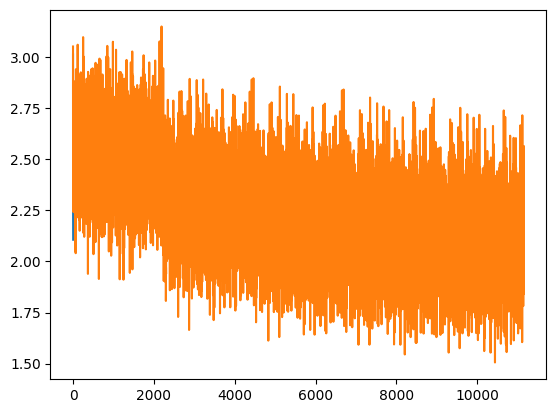

In [87]:
epochs = 5  # количество эпох
train_loss_hist, val_loss_hist = [], []  # сюда сохраним историю лоссов

for epoch in range(1, epochs + 1):

    print(f'--- Epoch {epoch} --- \n')
    print('Training...')
    pbar = tqdm(train_dataloader, total=len(train_dataloader))  # прогресс-бар для отслеживания обучения
    train_loss = 0
    for feats, targets in pbar:
        feats = feats.to(device)
        targets = targets.to(device)  
        optimizer.zero_grad()
        out = mlp(feats).to(torch.float32)  # получим выход модели
        curr_loss = loss_fn(out, targets)  # считаем лосс
        curr_loss.backward()
        optimizer.step()

        pbar.set_description(f'Current loss: {curr_loss.item():.5f}')
        train_loss += curr_loss.item()
    train_loss_hist.append(train_loss / len(train_dataloader))
    print(f'Average train loss: {train_loss / len(train_dataloader)}')

    print('Validating...')
    pbar = tqdm(val_dataloader, total=len(val_dataloader))
    val_loss = 0
    with torch.no_grad():
        for feats, targets in pbar:
            feats = feats.to(device)
            targets = targets.to(device)
            out = mlp(feats).to(torch.float32)  # получим выход модели
            curr_loss = loss_fn(out, targets)  # считаем лосс

            pbar.set_description(f'Current loss: {curr_loss.item():.5f}')
            val_loss += curr_loss.item()
    val_loss_hist.append(val_loss / len(val_dataloader))
    print(f'Average val loss: {val_loss / len(val_dataloader)}\n')

plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.show()  # покажем графики с лоссом

In [88]:
torch.save(mlp.state_dict(), 'mlp1.pt')  # сохранение модели 

## Подсчет метрик

Получаем финальные предсказания модели

In [103]:
y_pred = []

with torch.no_grad():
    for emb, target in tqdm(val_dataset):
        out = mlp(torch.tensor(emb).to(device).to(torch.float32))  
        label = out.argmax().item()  # выберем класс с наибольшей предсказанной вероятностью
        y_pred.append(label)
        
y_pred[:20]

100%|██████████| 142685/142685 [00:43<00:00, 3252.94it/s]


[88,
 58,
 10,
 60,
 75,
 118,
 19,
 24,
 113,
 75,
 19,
 19,
 81,
 88,
 56,
 88,
 88,
 25,
 110,
 75,
 49,
 11,
 56,
 49,
 88,
 11,
 44,
 49,
 49,
 84,
 19,
 25,
 90,
 75,
 82,
 85,
 49,
 75,
 1,
 75,
 10,
 88,
 58,
 85,
 49,
 56,
 56,
 52,
 100,
 88,
 51,
 88,
 75,
 49,
 49,
 46,
 84,
 56,
 29,
 25,
 25,
 25,
 48,
 56,
 25,
 29,
 59,
 25,
 23,
 84,
 11,
 25,
 49,
 18,
 56,
 85,
 19,
 88,
 113,
 24,
 87,
 88,
 75,
 10,
 56,
 49,
 49,
 25,
 49,
 11,
 49,
 56,
 44,
 49,
 49,
 11,
 106,
 19,
 56,
 75,
 47,
 25,
 25,
 11,
 49,
 75,
 29,
 29,
 28,
 13,
 29,
 25,
 10,
 56,
 13,
 10,
 84,
 49,
 10,
 90,
 10,
 49,
 19,
 7,
 65,
 49,
 24,
 25,
 80,
 60,
 113,
 49,
 19,
 56,
 17,
 49,
 49,
 113,
 88,
 56,
 10,
 30,
 10,
 13,
 65,
 10,
 19,
 90,
 19,
 26,
 88,
 10,
 88,
 75,
 78,
 50,
 100,
 25,
 88,
 49,
 100,
 88,
 59,
 49,
 8,
 49,
 46,
 17,
 46,
 88,
 88,
 66,
 44,
 49,
 10,
 27,
 75,
 91,
 11,
 49,
 10,
 56,
 103,
 25,
 11,
 13,
 88,
 87,
 49,
 49,
 19,
 47,
 23,
 40,
 49,
 30,
 75,
 81,
 1

In [117]:
text_y_pred = [ohe.get_feature_names_out()[i][3:] for i in tqdm(y_pred)]  
text_y_pred[:20]

100%|██████████| 142685/142685 [00:08<00:00, 16511.37it/s]


['специалист',
 'официант',
 'бухгалтер',
 'парикмахер',
 'продавец',
 'юрисконсульт',
 'директор',
 'заместитель',
 'электромонтер',
 'продавец',
 'директор',
 'директор',
 'руководитель',
 'специалист',
 'оператор',
 'специалист',
 'специалист',
 'инженер',
 'электрогазосварщик',
 'продавец']

In [118]:
y_true = ohe.inverse_transform(y_val).flatten().tolist()  # конвертируем OHE обратно в текст
y_true[:20]

['инженер',
 'официант',
 'бухгалтер',
 'мастер',
 'менеджер',
 'юрисконсульт',
 'директор',
 'директор',
 'электромонтер',
 'продавец',
 'заместитель',
 'руководитель',
 'специалист',
 'секретарь',
 'делопроизводитель',
 'директор',
 'делопроизводитель',
 'электромонтёр',
 'стропальщик',
 'продавец']

### Итоговые значения метрик

In [120]:
f1_score(y_true, text_y_pred, average='micro'), f1_score(y_true, text_y_pred, average='macro')

(0.427578231769282, 0.25021447447879636)

In [121]:
accuracy_score(y_true, text_y_pred)

0.427578231769282

In [126]:
mode_pred = df_small['job_title'].mode().tolist() * len(y_true)
f1_score(y_true, mode_pred, average='micro'), f1_score(y_true, mode_pred, average='macro')

(0.10000350422258822, 0.0015151997825265152)

Итого, наша модель показывает существенно лучшие результаты, чем бейзлайн